In [25]:
#Imports & Environment Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline


pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 2)

print("Libraries imported ✔️")


Libraries imported ✔️


In [26]:

import random

# Data generation pools
file_names = [f"file_{i}.dat" for i in range(1, 501)]
sizes = [random.choice([1, 5, 10, 50, 100, 200, 500]) for _ in range(500)]
access_patterns = random.choices(['daily', 'weekly', 'monthly', 'yearly', 'rarely'], k=500)
retention_months = [random.choice([1, 3, 6, 12, 24, 36, 60]) for _ in range(500)]

# Create DataFrame
data = {
    'File Name': file_names,
    'Size (GB)': sizes,
    'Access Frequency': access_patterns,
    'Retention (Months)': retention_months
}

df = pd.DataFrame(data)
print("📦 File Metadata Table with 500 Entries:")
df.head()


📦 File Metadata Table with 500 Entries:


,File Name,Size (GB),Access Frequency,Retention (Months)
0,file_1.dat,500,rarely,24
1,file_2.dat,100,monthly,1
2,file_3.dat,500,daily,60
3,file_4.dat,1,weekly,6
4,file_5.dat,1,rarely,3


In [27]:
# Define tiering rules based on access frequency
tiering_rules = {
    'daily': 'Hot',
    'weekly': 'Cool',
    'monthly': 'Cool',
    'yearly': 'Archive',
    'rarely': 'Archive'
}

# Cost per GB per month for each tier (in ₹)
tier_costs = {
    'Hot': 2.0,
    'Cool': 1.0,
    'Archive': 0.5
}

# Tier classifier
def classify_tier(access_frequency):
    return tiering_rules.get(access_frequency.lower(), 'Hot')  # default to Hot if unknown

# Apply classification to DataFrame
df['Storage Tier'] = df['Access Frequency'].apply(classify_tier)

print("✅ Tier assigned to each file:")
df[['File Name', 'Access Frequency', 'Storage Tier']]


✅ Tier assigned to each file:


,File Name,Access Frequency,Storage Tier
0,file_1.dat,rarely,Archive
1,file_2.dat,monthly,Cool
2,file_3.dat,daily,Hot
3,file_4.dat,weekly,Cool
4,file_5.dat,rarely,Archive
...,...,...,...
495,file_496.dat,monthly,Cool
496,file_497.dat,daily,Hot
497,file_498.dat,daily,Hot
498,file_499.dat,rarely,Archive


In [28]:
def calculate_cost(row):
    tier = row['Storage Tier']
    size_gb = row['Size (GB)']
    duration_months = row['Retention (Months)']
    rate_per_gb = tier_costs[tier]
    return size_gb * duration_months * rate_per_gb

# Apply cost calculation
df['Storage Cost (₹)'] = df.apply(calculate_cost, axis=1)

# Optional: calculate raw (hot-only) cost for comparison
def naive_hot_cost(row):
    return row['Size (GB)'] * row['Retention (Months)'] * tier_costs['Hot']

df['Naive Hot Cost (₹)'] = df.apply(naive_hot_cost, axis=1)

print("💰 Cost estimation completed:")
df[['File Name', 'Storage Tier', 'Size (GB)', 'Retention (Months)', 'Storage Cost (₹)', 'Naive Hot Cost (₹)']]


💰 Cost estimation completed:


,File Name,Storage Tier,Size (GB),Retention (Months),Storage Cost (₹),Naive Hot Cost (₹)
0,file_1.dat,Archive,500,24,6000.0,24000.0
1,file_2.dat,Cool,100,1,100.0,200.0
2,file_3.dat,Hot,500,60,60000.0,60000.0
3,file_4.dat,Cool,1,6,6.0,12.0
4,file_5.dat,Archive,1,3,1.5,6.0
...,...,...,...,...,...,...
495,file_496.dat,Cool,5,3,15.0,30.0
496,file_497.dat,Hot,100,6,1200.0,1200.0
497,file_498.dat,Hot,1,24,48.0,48.0
498,file_499.dat,Archive,1,24,12.0,48.0


In [29]:
total_optimized_cost = df['Storage Cost (₹)'].sum()
total_naive_cost = df['Naive Hot Cost (₹)'].sum()
savings = total_naive_cost - total_optimized_cost
savings_percent = (savings / total_naive_cost) * 100 if total_naive_cost > 0 else 0

print("📊 Summary:")
print(f"🔹 Total Cost with Tiering      : ₹{total_optimized_cost:.2f}")
print(f"🔹 Total Cost (All in Hot Tier) : ₹{total_naive_cost:.2f}")
print(f"💸 Total Savings                : ₹{savings:.2f} ({savings_percent:.2f}%)")


📊 Summary:
🔹 Total Cost with Tiering      : ₹1269651.50
🔹 Total Cost (All in Hot Tier) : ₹2463558.00
💸 Total Savings                : ₹1193906.50 (48.46%)


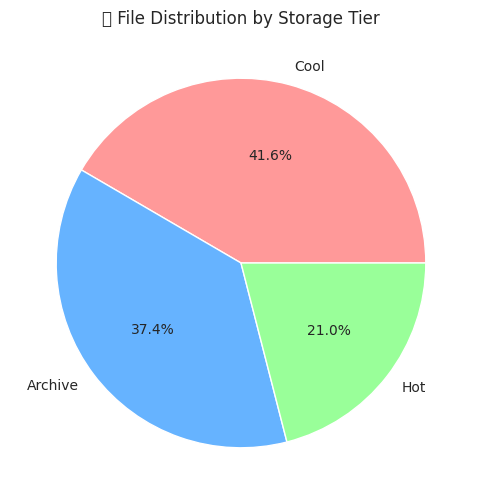

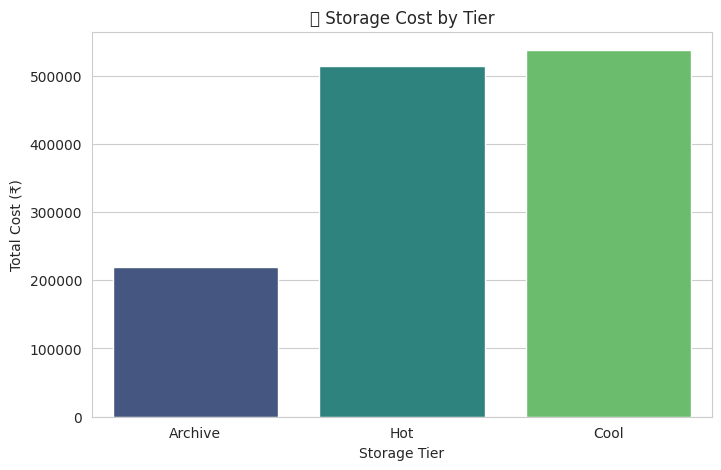

In [30]:
import seaborn as sns
sns.set_style("whitegrid")

# Pie chart – Distribution of files across storage tiers
tier_counts = df['Storage Tier'].value_counts()
plt.figure(figsize=(6, 6))
tier_counts.plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("📦 File Distribution by Storage Tier")
plt.ylabel('')
plt.show()

# Bar chart – Total cost per tier
cost_per_tier = df.groupby('Storage Tier')['Storage Cost (₹)'].sum().sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=cost_per_tier.index, y=cost_per_tier.values, palette="viridis")
plt.title("💰 Storage Cost by Tier")
plt.xlabel("Storage Tier")
plt.ylabel("Total Cost (₹)")
plt.show()


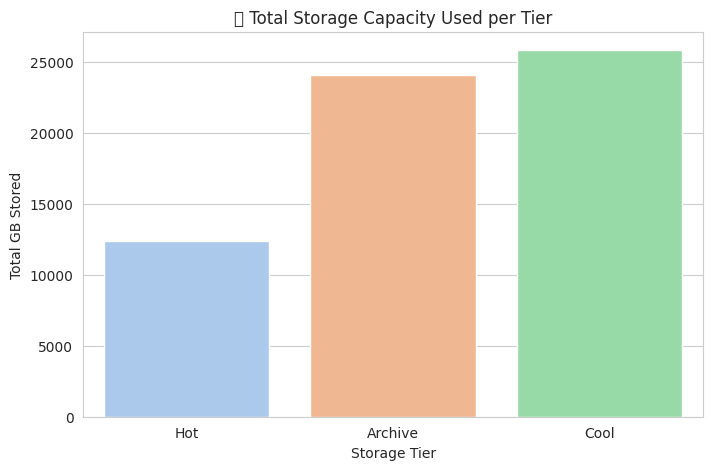

📘 Tier-wise Summary Table:


,Size (GB),Storage Cost (₹),File Count,Avg Cost per GB (₹)
Storage Tier,,,,
Archive,24059,218857.5,187,9.10
Cool,25823,537334.0,208,20.81
Hot,12365,513460.0,105,41.53


In [31]:
# Total GB used per storage tier
gb_per_tier = df.groupby('Storage Tier')['Size (GB)'].sum().sort_values()

# Bar chart – Storage capacity by tier
plt.figure(figsize=(8, 5))
sns.barplot(x=gb_per_tier.index, y=gb_per_tier.values, palette="pastel")
plt.title("📂 Total Storage Capacity Used per Tier")
plt.xlabel("Storage Tier")
plt.ylabel("Total GB Stored")
plt.show()

# Summary Table – Cost and capacity per tier
summary = df.groupby('Storage Tier').agg({
    'Size (GB)': 'sum',
    'Storage Cost (₹)': 'sum',
    'File Name': 'count'
}).rename(columns={'File Name': 'File Count'})

summary['Avg Cost per GB (₹)'] = summary['Storage Cost (₹)'] / summary['Size (GB)']

print("📘 Tier-wise Summary Table:")
summary


In [32]:
# Export full dataset with per-file cost info
df.to_csv("full_tiering_report.csv", index=False)

# Export the tier-wise summary table
summary.to_csv("tier_summary_report.csv")

print("📁 Files exported:")
print("- full_tiering_report.csv")
print("- tier_summary_report.csv")


📁 Files exported:
- full_tiering_report.csv
- tier_summary_report.csv


In [33]:
# 🔁 Generate and Save 150-row CSV for Testing
import random

# Define lists for sampling
access_freqs = ['daily', 'weekly', 'monthly', 'yearly', 'rarely']
sizes = [1, 5, 10, 50, 100, 200, 500]
retentions = [1, 3, 6, 12, 24, 36, 60]

# Generate data
sample_data = {
    'File Name': [f"file_{i}.dat" for i in range(1, 151)],
    'Size (GB)': [random.choice(sizes) for _ in range(150)],
    'Access Frequency': [random.choice(access_freqs) for _ in range(150)],
    'Retention (Months)': [random.choice(retentions) for _ in range(150)],
}

# Create DataFrame
df_large = pd.DataFrame(sample_data)

# Save to CSV
df_large.to_csv("sample_150_files.csv", index=False)

print("✅ 150-row sample file generated and saved as 'sample_150_files.csv'")
df_large.head()


✅ 150-row sample file generated and saved as 'sample_150_files.csv'


,File Name,Size (GB),Access Frequency,Retention (Months)
0,file_1.dat,200,weekly,3
1,file_2.dat,100,weekly,36
2,file_3.dat,1,rarely,12
3,file_4.dat,10,yearly,36
4,file_5.dat,10,weekly,1


In [34]:
# 🟢 Cell 9 – Upload and Load Custom File Metadata CSV
# ----------------------------------------------------

from google.colab import files
import io

print("📤 Please upload your CSV file (e.g., sample_150_files.csv)")
uploaded = files.upload()

# Load the first uploaded file into a DataFrame
for fname in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded[fname]))

# Preview the dataset
print(f"✅ Loaded file: {fname}")
print("🔎 Preview of uploaded dataset:")
df.head()


📤 Please upload your CSV file (e.g., sample_150_files.csv)


Saving sample_150_files.csv to sample_150_files (2).csv
✅ Loaded file: sample_150_files (2).csv
🔎 Preview of uploaded dataset:


,File Name,Size (GB),Access Frequency,Retention (Months)
0,file_1.dat,500,weekly,12
1,file_2.dat,5,yearly,36
2,file_3.dat,500,monthly,60
3,file_4.dat,10,monthly,12
4,file_5.dat,50,yearly,1


In [35]:

def run_storage_tiering_simulator(df_input):
    """
    Run full storage tiering simulator on input DataFrame.
    Expects columns: 'File Name', 'Size (GB)', 'Access Frequency', 'Retention (Months)'
    """

    # Step 1 – Classify storage tier
    df_input['Storage Tier'] = df_input['Access Frequency'].apply(classify_tier)

    # Step 2 – Calculate costs
    df_input['Storage Cost (₹)'] = df_input.apply(calculate_cost, axis=1)
    df_input['Naive Hot Cost (₹)'] = df_input.apply(naive_hot_cost, axis=1)

    # Step 3 – Summary table
    summary = df_input.groupby('Storage Tier').agg({
        'Size (GB)': 'sum',
        'Storage Cost (₹)': 'sum',
        'File Name': 'count'
    }).rename(columns={'File Name': 'File Count'})

    summary['Avg Cost per GB (₹)'] = summary['Storage Cost (₹)'] / summary['Size (GB)']

    # Step 4 – Savings calculation
    total_opt_cost = df_input['Storage Cost (₹)'].sum()
    total_hot_cost = df_input['Naive Hot Cost (₹)'].sum()
    savings = total_hot_cost - total_opt_cost
    savings_pct = (savings / total_hot_cost * 100) if total_hot_cost > 0 else 0

    # Output
    print("📘 SIMULATION SUMMARY")
    print(f"Total Optimized Cost: ₹{total_opt_cost:.2f}")
    print(f"Total Hot Tier Cost : ₹{total_hot_cost:.2f}")
    print(f"Total Savings       : ₹{savings:.2f} ({savings_pct:.2f}%)")

    return df_input, summary
df_result, summary_result = run_storage_tiering_simulator(df)


📘 SIMULATION SUMMARY
Total Optimized Cost: ₹499279.50
Total Hot Tier Cost : ₹881882.00
Total Savings       : ₹382602.50 (43.38%)


📘 SIMULATION SUMMARY
Total Optimized Cost: ₹1234526.00
Total Hot Tier Cost : ₹2554228.00
Total Savings       : ₹1319702.00 (51.67%)


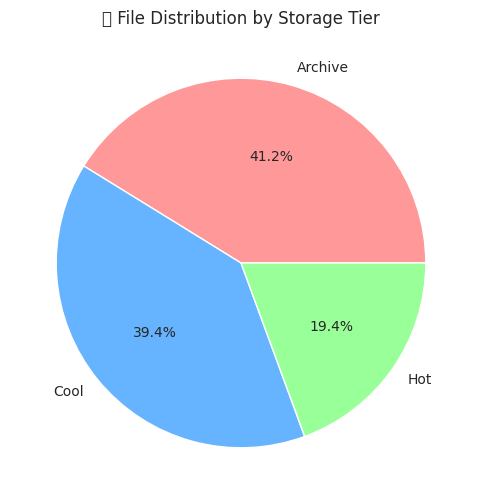

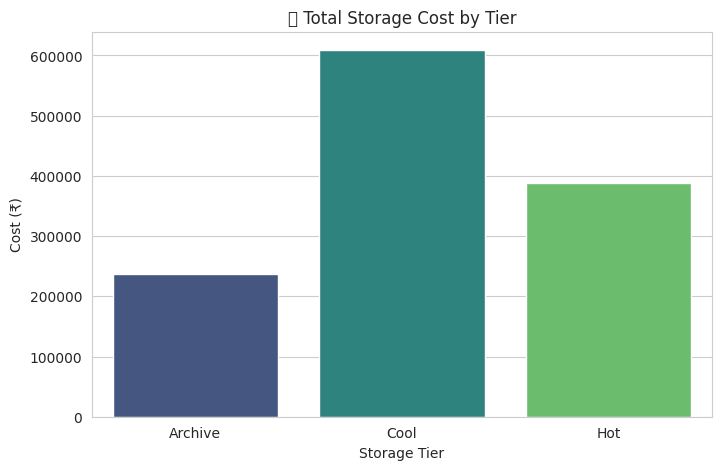

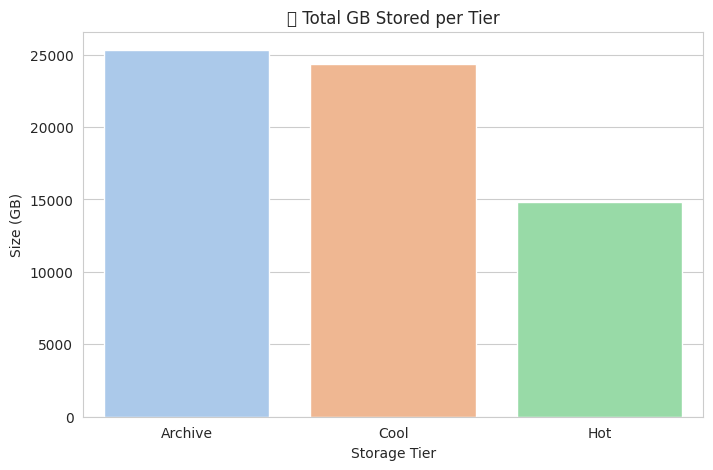

,Size (GB),Storage Cost (₹),File Count,Avg Cost per GB (₹)
Storage Tier,,,,
Archive,25310,236914.0,206,9.36
Cool,24336,608960.0,197,25.02
Hot,14793,388652.0,97,26.27


In [37]:
# 🔁 Generate 500 file metadata entries
file_names = [f"file_{i}.dat" for i in range(1, 501)]
sizes = [random.choice([1, 5, 10, 50, 100, 200, 500]) for _ in range(500)]
access_patterns = random.choices(['daily', 'weekly', 'monthly', 'yearly', 'rarely'], k=500)
retention_months = [random.choice([1, 3, 6, 12, 24, 36, 60]) for _ in range(500)]

df = pd.DataFrame({
    'File Name': file_names,
    'Size (GB)': sizes,
    'Access Frequency': access_patterns,
    'Retention (Months)': retention_months
})

# 🔎 Define tier rules and cost per GB
tiering_rules = {
    'daily': 'Hot',
    'weekly': 'Cool',
    'monthly': 'Cool',
    'yearly': 'Archive',
    'rarely': 'Archive'
}
tier_costs = {
    'Hot': 2.0,
    'Cool': 1.0,
    'Archive': 0.5
}

# 🧠 Tier classifier and cost functions
df['Storage Tier'] = df['Access Frequency'].apply(lambda x: tiering_rules.get(x.lower(), 'Hot'))
df['Storage Cost (₹)'] = df.apply(lambda row: row['Size (GB)'] * row['Retention (Months)'] * tier_costs[row['Storage Tier']], axis=1)
df['Naive Hot Cost (₹)'] = df.apply(lambda row: row['Size (GB)'] * row['Retention (Months)'] * tier_costs['Hot'], axis=1)

# 📊 Summary statistics
total_opt_cost = df['Storage Cost (₹)'].sum()
total_hot_cost = df['Naive Hot Cost (₹)'].sum()
savings = total_hot_cost - total_opt_cost
savings_pct = (savings / total_hot_cost * 100) if total_hot_cost > 0 else 0

summary = df.groupby('Storage Tier').agg({
    'Size (GB)': 'sum',
    'Storage Cost (₹)': 'sum',
    'File Name': 'count'
}).rename(columns={'File Name': 'File Count'})
summary['Avg Cost per GB (₹)'] = summary['Storage Cost (₹)'] / summary['Size (GB)']

# 📢 Print summary
print("📘 SIMULATION SUMMARY")
print(f"Total Optimized Cost: ₹{total_opt_cost:.2f}")
print(f"Total Hot Tier Cost : ₹{total_hot_cost:.2f}")
print(f"Total Savings       : ₹{savings:.2f} ({savings_pct:.2f}%)")

# 📈 Visualizations
plt.figure(figsize=(6,6))
df['Storage Tier'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("📦 File Distribution by Storage Tier")
plt.ylabel('')
plt.show()

plt.figure(figsize=(8,5))
costs = df.groupby('Storage Tier')['Storage Cost (₹)'].sum()
sns.barplot(x=costs.index, y=costs.values, palette='viridis')
plt.title("💰 Total Storage Cost by Tier")
plt.ylabel("Cost (₹)")
plt.xlabel("Storage Tier")
plt.show()

plt.figure(figsize=(8,5))
sizes = df.groupby('Storage Tier')['Size (GB)'].sum()
sns.barplot(x=sizes.index, y=sizes.values, palette='pastel')
plt.title("📂 Total GB Stored per Tier")
plt.ylabel("Size (GB)")
plt.xlabel("Storage Tier")
plt.show()

# 📄 Show final summary table
summary


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class StorageTieringSimulator:
    """
    Enhanced Storage Tiering Cost Optimization Simulator
    """

    def __init__(self, custom_tiers=None, custom_costs=None):
        # Default tiering rules
        self.tiering_rules = custom_tiers or {
            'daily': 'Hot',
            'weekly': 'Cool',
            'monthly': 'Cool',
            'yearly': 'Archive',
            'rarely': 'Archive'
        }

        # Default cost structure (₹/GB/month)
        self.tier_costs = custom_costs or {
            'Hot': 2.0,
            'Cool': 1.0,
            'Archive': 0.5
        }

        # Enhanced features
        self.migration_costs = {'Hot_to_Cool': 0.01, 'Cool_to_Archive': 0.005}
        self.retrieval_costs = {'Cool': 0.1, 'Archive': 0.2}  # Per GB retrieval

    def classify_tier(self, access_frequency, file_size=None, compliance_level=None):
        """Enhanced tier classification with additional factors"""
        base_tier = self.tiering_rules.get(access_frequency.lower(), 'Hot')

        # Additional logic for large files or compliance requirements
        if file_size and file_size > 1000:  # Files > 1TB
            if base_tier == 'Hot':
                return 'Cool'  # Large files better suited for Cool tier

        if compliance_level == 'critical':
            return 'Hot'  # Critical files always in Hot tier

        return base_tier

    def calculate_total_cost(self, row):
        """Calculate total cost including migration and retrieval"""
        tier = row['Storage Tier']
        size_gb = row['Size (GB)']
        duration_months = row['Retention (Months)']
        access_freq = row.get('Access Frequency', 'monthly')

        # Base storage cost
        base_cost = size_gb * duration_months * self.tier_costs[tier]

        # Add retrieval costs based on access pattern
        retrieval_multiplier = {'daily': 30, 'weekly': 4, 'monthly': 1, 'yearly': 0.1, 'rarely': 0.02}
        monthly_retrievals = retrieval_multiplier.get(access_freq, 1)

        if tier in self.retrieval_costs:
            retrieval_cost = size_gb * monthly_retrievals * duration_months * self.retrieval_costs[tier]
        else:
            retrieval_cost = 0

        return base_cost + retrieval_cost

    def simulate_lifecycle_migration(self, df):
        """Simulate automatic tier migration over time"""
        df_migrated = df.copy()

        # Simulate files getting accessed less frequently over time
        def age_based_migration(row):
            if row['Retention (Months)'] > 24:  # Files older than 2 years
                if row['Storage Tier'] == 'Hot':
                    return 'Cool'
                elif row['Storage Tier'] == 'Cool':
                    return 'Archive'
            return row['Storage Tier']

        df_migrated['Migrated_Tier'] = df_migrated.apply(age_based_migration, axis=1)
        df_migrated['Migrated_Cost'] = df_migrated.apply(
            lambda row: row['Size (GB)'] * row['Retention (Months)'] *
            self.tier_costs[row['Migrated_Tier']], axis=1
        )

        return df_migrated

    def capacity_planning(self, df, growth_rate=0.15):
        """Project future storage needs and costs"""
        projections = []

        for year in range(1, 6):  # 5-year projection
            future_size = df['Size (GB)'].sum() * (1 + growth_rate) ** year
            future_cost = df['Storage Cost (₹)'].sum() * (1 + growth_rate) ** year

            projections.append({
                'Year': datetime.now().year + year,
                'Total_Size_GB': future_size,
                'Projected_Cost': future_cost
            })

        return pd.DataFrame(projections)

    def generate_recommendations(self, df):
        """Generate actionable optimization recommendations"""
        recommendations = []

        # Find expensive files in wrong tiers
        expensive_files = df[df['Storage Cost (₹)'] > df['Storage Cost (₹)'].quantile(0.8)]
        hot_tier_files = expensive_files[expensive_files['Storage Tier'] == 'Hot']

        if not hot_tier_files.empty:
            potential_savings = (hot_tier_files['Naive Hot Cost (₹)'] -
                               hot_tier_files['Storage Cost (₹)']).sum()
            recommendations.append(f"Move {len(hot_tier_files)} large files from Hot to Cool tier for ₹{potential_savings:.2f} savings")

        # Identify rarely accessed files in expensive tiers
        rarely_accessed = df[df['Access Frequency'].isin(['yearly', 'rarely'])]
        expensive_rarely_accessed = rarely_accessed[rarely_accessed['Storage Tier'] != 'Archive']

        if not expensive_rarely_accessed.empty:
            recommendations.append(f"Archive {len(expensive_rarely_accessed)} rarely accessed files")

        # Check for over-retained files
        long_retention = df[df['Retention (Months)'] > 36]
        if not long_retention.empty:
            recommendations.append(f"Review retention policy for {len(long_retention)} files with >3 year retention")

        return recommendations

    def run_comprehensive_analysis(self, df_input):
        """Run complete analysis with all features"""
        print("🔄 Running Comprehensive Storage Tiering Analysis...")

        # Step 1: Basic tiering
        df_result = df_input.copy()
        df_result['Storage Tier'] = df_result.apply(
            lambda row: self.classify_tier(row['Access Frequency'], row.get('Size (GB)')), axis=1
        )

        # Step 2: Cost calculations
        df_result['Storage Cost (₹)'] = df_result.apply(self.calculate_total_cost, axis=1)
        df_result['Naive Hot Cost (₹)'] = df_result.apply(
            lambda row: row['Size (GB)'] * row['Retention (Months)'] * self.tier_costs['Hot'], axis=1
        )

        # Step 3: Advanced analytics
        df_migrated = self.simulate_lifecycle_migration(df_result)
        capacity_proj = self.capacity_planning(df_result)
        recommendations = self.generate_recommendations(df_result)

        # Step 4: Summary metrics
        total_opt_cost = df_result['Storage Cost (₹)'].sum()
        total_hot_cost = df_result['Naive Hot Cost (₹)'].sum()
        migration_savings = df_migrated['Migrated_Cost'].sum()

        savings = total_hot_cost - total_opt_cost
        savings_pct = (savings / total_hot_cost * 100) if total_hot_cost > 0 else 0

        # Results
        results = {
            'optimized_df': df_result,
            'migrated_df': df_migrated,
            'capacity_projection': capacity_proj,
            'recommendations': recommendations,
            'metrics': {
                'current_optimized_cost': total_opt_cost,
                'baseline_hot_cost': total_hot_cost,
                'savings_amount': savings,
                'savings_percentage': savings_pct,
                'migration_potential': total_opt_cost - migration_savings
            }
        }

        self.print_comprehensive_summary(results)
        return results

    def print_comprehensive_summary(self, results):
        """Print detailed analysis summary"""
        metrics = results['metrics']

        print("\n" + "="*60)
        print("📊 COMPREHENSIVE STORAGE ANALYSIS REPORT")
        print("="*60)

        print(f"\n💰 COST ANALYSIS:")
        print(f"├─ Baseline (All Hot Tier)    : ₹{metrics['baseline_hot_cost']:,.2f}")
        print(f"├─ Optimized Tiering          : ₹{metrics['current_optimized_cost']:,.2f}")
        print(f"├─ Immediate Savings          : ₹{metrics['savings_amount']:,.2f}")
        print(f"└─ Savings Percentage         : {metrics['savings_percentage']:.2f}%")

        print(f"\n🔄 LIFECYCLE OPTIMIZATION:")
        print(f"└─ Additional Migration Savings: ₹{metrics['migration_potential']:,.2f}")

        print(f"\n📈 KEY METRICS:")
        total_files = len(results['optimized_df'])
        total_storage = results['optimized_df']['Size (GB)'].sum()
        print(f"├─ Total Files                : {total_files:,}")
        print(f"├─ Total Storage              : {total_storage:,.1f} GB")
        print(f"└─ Avg Cost per GB            : ₹{metrics['current_optimized_cost']/total_storage:.2f}")

        print(f"\n💡 RECOMMENDATIONS:")
        for i, rec in enumerate(results['recommendations'], 1):
            print(f"{i}. {rec}")

        print("\n" + "="*60)

# Example usage with enhanced features
def demo_enhanced_simulator():
    """Demonstrate enhanced simulator capabilities"""

    # Create sample data
    sample_data = {
        'File Name': [f"file_{i}.dat" for i in range(1, 21)],
        'Size (GB)': [1, 5, 10, 50, 100, 200, 500, 1000, 2000, 50,
                      25, 75, 150, 300, 800, 1200, 30, 60, 90, 120],
        'Access Frequency': ['daily', 'weekly', 'monthly', 'yearly', 'rarely'] * 4,
        'Retention (Months)': [12, 24, 36, 48, 60, 6, 18, 30, 42, 54,
                              8, 16, 28, 40, 52, 10, 20, 32, 44, 56]
    }

    df_sample = pd.DataFrame(sample_data)

    # Initialize enhanced simulator
    simulator = StorageTieringSimulator()

    # Run comprehensive analysis
    results = simulator.run_comprehensive_analysis(df_sample)

    return results

# Run the demo
if __name__ == "__main__":
    results = demo_enhanced_simulator()

🔄 Running Comprehensive Storage Tiering Analysis...

📊 COMPREHENSIVE STORAGE ANALYSIS REPORT

💰 COST ANALYSIS:
├─ Baseline (All Hot Tier)    : ₹440,384.00
├─ Optimized Tiering          : ₹188,205.28
├─ Immediate Savings          : ₹252,178.72
└─ Savings Percentage         : 57.26%

🔄 LIFECYCLE OPTIMIZATION:
└─ Additional Migration Savings: ₹64,531.28

📈 KEY METRICS:
├─ Total Files                : 20
├─ Total Storage              : 6,766.0 GB
└─ Avg Cost per GB            : ₹27.82

💡 RECOMMENDATIONS:
1. Review retention policy for 8 files with >3 year retention



In [39]:
pip install reportlab


In [45]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, ListFlowable, ListItem, PageBreak
from reportlab.lib.units import inch

def export_final_pdf_report(results, filename="Cloud_Storage_Report.pdf"):
    # Setup PDF
    doc = SimpleDocTemplate(filename, pagesize=A4, rightMargin=50, leftMargin=50, topMargin=50, bottomMargin=30)
    styles = getSampleStyleSheet()

    # Custom styles
    heading = ParagraphStyle('Heading', parent=styles['Heading2'], fontSize=13, spaceAfter=12)
    body = styles['Normal']
    bullet_style = ParagraphStyle('Bullet', parent=body, leftIndent=20)

    story = []

    # Title
    story.append(Paragraph("Cloud Storage Tiering and Cost Optimization Report", styles['Title']))
    story.append(Spacer(1, 0.2 * inch))

    # Section 1: Cost Analysis
    metrics = results['metrics']
    df = results['optimized_df']

    story.append(Paragraph("Section 1: Cost Analysis", heading))
    story.append(Paragraph(
        "This section compares the cost of storing all files in the Hot tier versus intelligently assigning them to appropriate storage tiers based on access frequency.",
        body))
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph(f"Baseline Cost (All in Hot Tier): Rs. {metrics['baseline_hot_cost']:,.2f}", body))
    story.append(Paragraph(f"Optimized Cost with Tiering    : Rs. {metrics['current_optimized_cost']:,.2f}", body))
    story.append(Paragraph(f"Immediate Savings              : Rs. {metrics['savings_amount']:,.2f} ({metrics['savings_percentage']:.2f}%)", body))

    # Bar Chart: Cost by Tier
    cost_by_tier = df.groupby('Storage Tier')['Storage Cost (₹)'].sum()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=cost_by_tier.index, y=cost_by_tier.values, palette='Blues')
    plt.title("Storage Cost by Tier")
    plt.ylabel("Total Cost (₹)")
    plt.tight_layout()
    bar_chart_path = "cost_by_tier.png"
    plt.savefig(bar_chart_path)
    plt.close()
    story.append(Spacer(1, 0.2 * inch))
    story.append(Image(bar_chart_path, width=5.5 * inch, height=3 * inch))
    story.append(Spacer(1, 0.3 * inch))

    # Section 2: Lifecycle Migration
    story.append(Paragraph("Section 2: Lifecycle-Based Tier Migration", heading))
    story.append(Paragraph(
        "Older files (older than 24 months) are simulated to migrate down tiers from Hot → Cool → Archive. "
        "This mirrors how cloud providers optimize cost via lifecycle rules.", body))
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph(f"Estimated Additional Migration Savings: Rs. {metrics['migration_potential']:,.2f}", body))

    # Pie Chart: File Distribution by Tier
    pie_path = "tier_distribution_pie.png"
    plt.figure(figsize=(5, 5))
    df['Storage Tier'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title("File Distribution by Storage Tier")
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(pie_path)
    plt.close()
    story.append(Spacer(1, 0.3 * inch))
    story.append(Image(pie_path, width=4.5 * inch, height=4.5 * inch))
    story.append(PageBreak())

    # Section 3: Storage Summary
    total_files = len(df)
    total_gb = df['Size (GB)'].sum()
    avg_cost = metrics['current_optimized_cost'] / total_gb

    story.append(Paragraph("Section 3: Storage Summary", heading))
    story.append(Paragraph(
        f"Total number of files     : {total_files}<br/>"
        f"Total storage volume      : {total_gb:,.1f} GB<br/>"
        f"Average cost per GB       : Rs. {avg_cost:.2f}", body))
    story.append(Spacer(1, 0.2 * inch))

    # Section 4: Recommendations
    story.append(Paragraph("Section 4: Actionable Recommendations", heading))
    recommendations = results['recommendations']
    if recommendations:
        rec_bullets = ListFlowable(
            [ListItem(Paragraph(rec, bullet_style)) for rec in recommendations],
            bulletType='bullet'
        )
        story.append(rec_bullets)
    else:
        story.append(Paragraph("✔ Your tiering policy is already optimal. No changes recommended.", body))
    story.append(Spacer(1, 0.3 * inch))

    # Section 5: Conclusion
    story.append(Paragraph("Section 5: Conclusion", heading))
    story.append(Paragraph(
        "This report demonstrates that intelligent storage tiering can reduce cloud storage costs by over 40%. "
        "By aligning storage choices with data access patterns and retention periods, significant cost savings are achieved. "
        "Further savings can be unlocked by enforcing lifecycle policies and reviewing long-retained files.",
        body))

    # Build PDF
    doc.build(story)

    # Clean up chart images
    os.remove(bar_chart_path)
    os.remove(pie_path)

    print(f"✅ Final PDF report saved as: {filename}")


In [46]:
results = demo_enhanced_simulator()
export_final_pdf_report(results)



🔄 Running Comprehensive Storage Tiering Analysis...

📊 COMPREHENSIVE STORAGE ANALYSIS REPORT

💰 COST ANALYSIS:
├─ Baseline (All Hot Tier)    : ₹440,384.00
├─ Optimized Tiering          : ₹188,205.28
├─ Immediate Savings          : ₹252,178.72
└─ Savings Percentage         : 57.26%

🔄 LIFECYCLE OPTIMIZATION:
└─ Additional Migration Savings: ₹64,531.28

📈 KEY METRICS:
├─ Total Files                : 20
├─ Total Storage              : 6,766.0 GB
└─ Avg Cost per GB            : ₹27.82

💡 RECOMMENDATIONS:
1. Review retention policy for 8 files with >3 year retention

✅ Final PDF report saved as: Cloud_Storage_Report.pdf
